In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import task_generation, learning
import tqdm, plots, datetime

# choose a subset of tasks to learn
task_list = ['PRO_D', 'ANTI_D', 'PRO_M', 'ANTI_M']
n_trials = 100
nx = 2
sigma = 0.1
p_stay = 0.95
min_Te = 50
x_oracle = False

np.random.seed(0)

trials, epoch_list = task_generation.generate_trials(
    task_list, n_trials, nx, sigma, p_stay, min_Te)

nc = len(task_list)
nz = len(epoch_list)

true_M, true_W, true_p0_z = task_generation.get_ground_truth(
    task_list, epoch_list, p_stay=p_stay, nx=nx)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# get ground-truth delay/fixation epoch w
import sklearn.cluster
init_W = np.zeros_like(true_W)  # Nx x Nz x D
w_fixate = task_generation.make_delay_or_fixation_epoch(None, 1, 0, 0)
w_fixate = np.concatenate([w_fixate['s'], w_fixate['y']], axis=1)

init_W[:, 0, :] = w_fixate  # assign delay/fixation to the z=0 slot

familar_cx = np.zeros((nc, nx), dtype=np.int16)  # record which (c, x_hat) pairs have been seen
familiar_xz = np.zeros((nx, nz), dtype=np.int16)  # record which (x_hat, z) pairs have been seen
num_epochs_each_task = [len(np.unique(task_generation.task_dict[task_type].split('->'))) for task_type in task_list]


def check_for_matching_w(W, w):
    assert W.shape[-1] == len(w)
    dist = np.linalg.norm(W - w, axis=-1)

    if np.min(dist) > 0.5:
        return None
    else:
        return np.where(dist == np.min(dist))[0]
    

def get_ordered_clusters(obs, n_clusters):
    kmeans = sklearn.cluster.KMeans(
    n_clusters=num_epochs_each_task[c], random_state=0).fit(obs)
    seen = set()
    ordered_centers = []
    for l in kmeans.labels_:
        if l not in seen:
            seen.add(l)
            ordered_centers.append(kmeans.cluster_centers_[l])
    return ordered_centers

ws_over_time = []

for i in range(n_trials):
    c, _, sy = trials[i]
    obs = np.concatenate([sy['s'], sy['y']], axis=1)

    # do k-means clustering; sort the clusters in order of first appearance
    ordered_centers = get_ordered_clusters(obs, num_epochs_each_task[c])

    # remove clusters matching the fixation/delay epoch
    
    non_fixate_centers = []
    for j, w in enumerate(ordered_centers):
        if np.linalg.norm(w - w_fixate) < 0.5:
            continue
        non_fixate_centers.append(w)

    # by default, assume the putative x of this epoch to be the next one not yet seen in this task
      

    # for each of the clusters, look for matches in the current init_W. If so,
    # record the putative x associated with the matching row in init_W.
    n_matched_clusters = 0
    matched_xs = set()
    unmatched_centers = []

    for w in non_fixate_centers:
        match = check_for_matching_w(init_W, w)
        if match is not None:
            matched_xs.add(match[0])
            n_matched_clusters += 1
        else:
            unmatched_centers.append(w)

    
    if n_matched_clusters == len(non_fixate_centers):
        print('all centers matched')
        # there is nothing left to initialize for this (c, x) pair
        ws_over_time.append(init_W.copy())
        continue

    putative_x = None
    if len(matched_xs) == 0:
        putative_x = np.sum(familar_cx[c])  # next available x will be the putative x for this trial
    else:
        assert len(matched_xs) == 1  # even if there are multiple matches, they should have the same putative x
        putative_x = list(matched_xs)[0]

    # compute the occupancy of the current init_W with this putative x
    init_w_occupied = init_W.sum(-1)[putative_x]

    # assign the unmatched centers to the next available z slots
    available_z_slots = np.where(init_w_occupied == 0)[0]


    assert len(available_z_slots) >= len(unmatched_centers)
    for j, w in enumerate(unmatched_centers):
        init_W[putative_x, available_z_slots[j]] = w

    familar_cx[c, putative_x] = 1

    ws_over_time.append(init_W.copy())


all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched
all centers matched


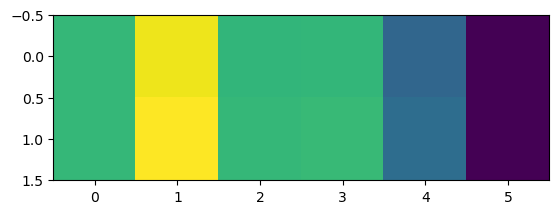

In [4]:
plt.imshow(init_W.sum(-1))

In [ ]:
def dynamic_initialize_W(trial,
                         num_epochs_this_task,
                         w_fixate,
                         match_criterion=0.5):    
    c, _, sy = trial
    obs = np.concatenate([sy['s'], sy['y']], axis=1)

    # do k-means clustering; sort the clusters in order of first appearance
    ordered_centers = get_ordered_clusters(obs, num_epochs_this_task[c])

    # remove clusters matching the fixation/delay epoch

    non_fixate_centers = []
    for j, w in enumerate(ordered_centers):
        if np.linalg.norm(w - w_fixate) < match_criterion:
            continue
        non_fixate_centers.append(w)

    # by default, assume the putative x of this epoch to be the next one not yet seen in this task
      

    # for each of the clusters, look for matches in the current init_W. If so,
    # record the putative x associated with the matching row in init_W.
    n_matched_clusters = 0
    matched_xs = set()
    unmatched_centers = []

    for w in non_fixate_centers:
        match = check_for_matching_w(init_W, w)
        if match is not None:
            matched_xs.add(match[0])
            n_matched_clusters += 1
        else:
            unmatched_centers.append(w)

    
    if n_matched_clusters == len(non_fixate_centers):
        print('all centers matched')
        # there is nothing left to initialize for this (c, x) pair
        ws_over_time.append(init_W.copy())
        continue

    putative_x = None
    if len(matched_xs) == 0:
        putative_x = np.sum(familar_cx[c])  # next available x will be the putative x for this trial
    else:
        assert len(matched_xs) == 1  # even if there are multiple matches, they should have the same putative x
        putative_x = list(matched_xs)[0]

    # compute the occupancy of the current init_W with this putative x
    init_w_occupied = init_W.sum(-1)[putative_x]

    # assign the unmatched centers to the next available z slots
    available_z_slots = np.where(init_w_occupied == 0)[0]


    assert len(available_z_slots) >= len(unmatched_centers)
    for j, w in enumerate(unmatched_centers):
        init_W[putative_x, available_z_slots[j]] = w

    familar_cx[c, putative_x] = 1

array([[ True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True, False]])

In [ ]:

        
    
check_for_matching_w(init_W, w_fixate)

(2, 6)
[1]


6

In [ ]:


epochs_each_task = [np.unique(task_generation.task_dict[task_type].split('->')) for task_type in task_list]
init_W = np.zeros_like(true_W)

familar_cx = np.zeros((nc, nx))

for i in range(n_trials):
    c, _, sy = trials[i]
    obs = np.concatenate([sy['s'], sy['y']], axis=1)
    epochs_this_trial = epochs_each_task[c]

    # do k-means clustering
    n_clusters = len(epochs_this_trial)
    kmeans = sklearn.cluster.KMeans(
        n_clusters=n_clusters, random_state=0).fit(obs)
    seen = set()
    ordered_centers = []
    for l in kmeans.labels_:
        if l not in seen:
            seen.add(l)
            ordered_centers.append(l)

    if familar_cx[c].sum() == nx:
        # all w slots for this task have been initialized
        continue

    elif 0 < familar_cx[c].sum() < nx:

        # decide whether this (c,x) has been seen before
        min_dists = []
        for center in kmeans.cluster_centers_:
            dist = np.linalg.norm(init_W - center, axis=-1)
            min_dists.append(np.min(dist))
        if np.max(min_dists) < 0.1:
            # this (c,x) has been seen before
            continue

        # claim the next x slot
        x_slot_ind = familar_cx[c].sum()

    for center in kmeans.cluster_centers_:
        # find the closest epoch
        dist = np.linalg.norm(true_W - center, axis=-1)
        if np.min(dist) < 0.1:
            # this cluster has been seen before
            continue
        closest_epoch = np.argmin(dist)
        init_W[closest_epoch] = center
        initialized[closest_epoch] = True


IndexError: index 7 is out of bounds for axis 0 with size 2

In [3]:

# learning parameters

initialize_with_true_w = True
true_w_noise_std = 0
lr = 0.02
eps=1e-10
n_sweeps = 1
iters_per_trial = 1
suff_stats_discount = 1
x_oracle=False
permute_trials = False

np.random.seed(0)

# initialize parameters to learn
# init_M = np.random.rand(nc, nz, nz)
init_M = np.ones((nc, nz, nz))
init_M /= init_M.sum(-1, keepdims=True)

init_W = np.random.normal(np.zeros_like(true_W))
# w_table[:, FD_ind, :] = true_w_table[:, FD_ind, :]
if initialize_with_true_w:
    init_W = true_W + np.random.normal(0, true_w_noise_std, size=true_W.shape)

init_p0_z = np.ones(nz)
init_p0_z /= init_p0_z.sum()

W_over_time = []
M_over_time = []
gamma_over_time = []
W_numer_over_time = []
W_denom_over_time = []
transition_counts_over_time = []


nc, nz, _ = init_M.shape
nx = init_W.shape[0]

learned_W = init_W.copy()
learned_M = init_M.copy()
learned_p0_z = init_p0_z.copy()

LL_across_trials_over_time = []
LLpT_over_time = []

# initialize sufficient statistics
transition_counts = np.zeros((nc, nz, nz))
W_numer = np.zeros((nx, nz, 6))  # 6 is the dimension of stim + response
W_denom = np.zeros((nx, nz))

trials_to_learn = trials[np.random.permutation(len(trials))] if permute_trials else trials

for isweep in range(n_sweeps):
    
    for itrial in tqdm.trange(len(trials)):
        
        (learned_M,
        learned_W,
        learned_p0_z,
        W_numer,
        W_denom,
        transition_counts) = learning._online_learning_single_trial(
            curr_W=learned_W,
            curr_M=learned_M,
            curr_p0_z=learned_p0_z,
            curr_W_numer=W_numer,
            curr_W_denom=W_denom,
            curr_transition_counts=transition_counts,
            trial=trials_to_learn[itrial],
            lr=lr,
            iters_per_trial=iters_per_trial,
            eps=1e-10,
            sigma=sigma,
            w_update_threshold=1e-3,
            suff_stats_discount=suff_stats_discount,
            x_oracle=x_oracle)

        # gamma_over_time.append(gamma)

        # simple W magnitude correction
        # learned_W = true_W.copy()
        # for _x in range(nx):
        #     for _z in range(nz):
        #         learned_W[_x, _z] /= np.max(learned_W[_x, _z])
        W_over_time.append(learned_W)
        M_over_time.append(learned_M)
        W_numer_over_time.append(W_numer)
        W_denom_over_time.append(W_denom)
        transition_counts_over_time.append(transition_counts)



        if itrial % 5 == 0:
            # evaluate the final parameters on all the trials
            gamma_across_trials, LLpT, LL_across_trials = learning.get_stats_for_multiple_trials(
                trials, learned_W, learned_M, learned_p0_z, sigma, x_oracle)

            LL_across_trials_over_time.append(LL_across_trials)
            LLpT_over_time.append(LLpT)


100%|██████████| 100/100 [00:05<00:00, 18.22it/s]


In [4]:
_, true_LLpT, true_LL_across_trials = learning.get_stats_for_multiple_trials(
                trials, true_W, true_M, true_p0_z, sigma, x_oracle)

In [5]:
print(f' tasks={task_list} \
      \n epochs={epoch_list}, \n nx={nx}, sigma={sigma}, \
      \n p_stay={p_stay}, min_Te={min_Te}, x_oracle={x_oracle}, \
      \n initialize_with_true_w={initialize_with_true_w}, init_w_noise={true_w_noise_std}, ntrials={n_trials} \
      \n lr={lr}, suff_stats_discount={suff_stats_discount}, \
      \n iters_per_trial={iters_per_trial}, n_sweeps={n_sweeps}, \
      \n permute_trials={permute_trials}, \
      \n date: {datetime.datetime.now()} ')

 tasks=['PRO_D', 'ANTI_D', 'PRO_M', 'ANTI_M']       
 epochs=['F/D', 'S', 'R_A', 'R_M_P', 'R_P', 'R_M_A'], 
 nx=2, sigma=0.1,       
 p_stay=0.95, min_Te=20, x_oracle=False,       
 initialize_with_true_w=True, init_w_noise=0, ntrials=100       
 lr=0.02, suff_stats_discount=1,       
 iters_per_trial=1, n_sweeps=1,       
 permute_trials=False,       
 date: 2025-02-22 13:05:07.156416 


Text(0, 0.5, 'LLpT')

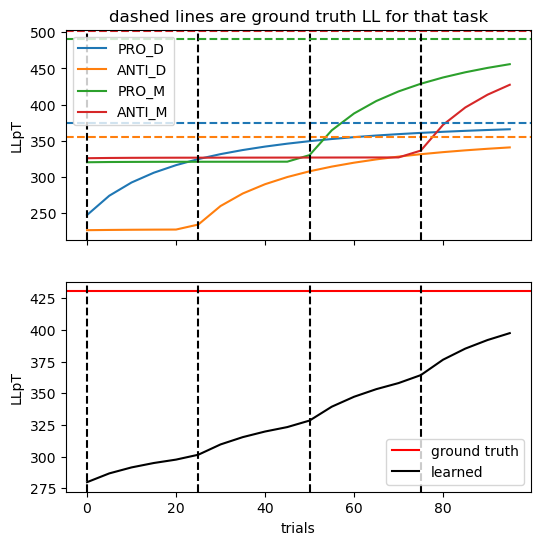

In [6]:
all_LLs = np.array(LL_across_trials_over_time)
n_trials_per_task = int(len(trials) / len(task_list))
LL_each_task_over_time = all_LLs.reshape(
    (-1, len(task_list), n_trials_per_task)).mean(2)
true_LL_across_trials_each_task = np.array(true_LL_across_trials).reshape(
    (-1, len(task_list), n_trials_per_task)).mean(2).flatten()

fig, axes = plt.subplots(figsize=(6, 6), nrows=2, ncols=1, sharex=True)
plt.sca(axes[0])
plt.plot(np.arange(len(all_LLs))*5, 
    LL_each_task_over_time, label=task_list)

plt.ylabel(f'LLpT')
for i in range(len(task_list)):
    plt.axvline(i * n_trials_per_task, color='k', linestyle='--')
    plt.axhline(true_LL_across_trials_each_task[i], color='C' + str(i), linestyle='--')
plt.legend()
plt.title('dashed lines are ground truth LL for that task')

plt.sca(axes[1])
plt.axhline(true_LLpT, label=f'ground truth', color='r')


plt.plot(np.arange(len(all_LLs))*5, LLpT_over_time,
         label='learned', color='k')
for i in range(len(task_list)):
    plt.axvline(i * n_trials_per_task, color='k', linestyle='--')
plt.legend()
plt.xlabel('trials')
plt.ylabel(f'LLpT')

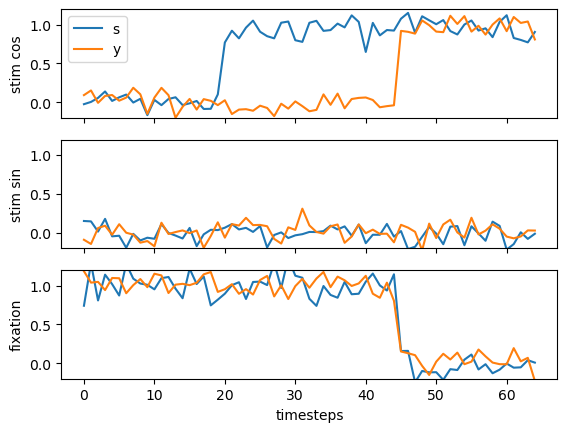

In [113]:
plots.plot_sy(trials[0][2])

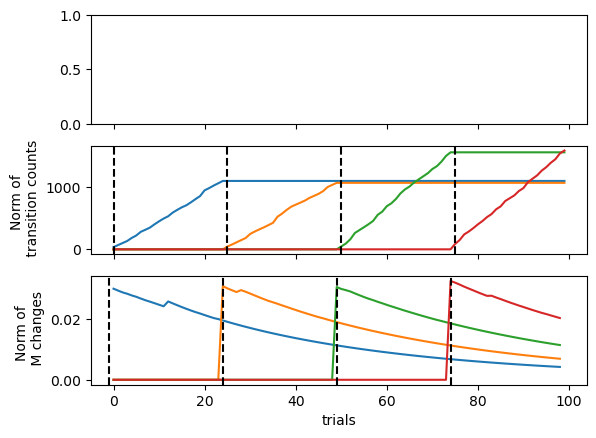

In [7]:


fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)
plt.sca(axes[0])
all_transition_countss = np.array(transition_counts_over_time).reshape(n_trials, len(task_list), -1)
transition_counts_norms = np.linalg.norm(all_transition_countss, axis=-1)
plt.sca(axes[1])
plt.plot(transition_counts_norms, label='task_list')
plt.ylabel ('Norm of \n transition counts')
for i in range(len(task_list)):
    plt.axvline(i * n_trials_per_task, color='k', linestyle='--')

all_Ms = np.array(M_over_time).reshape(n_trials, len(task_list), -1)
M_diff = np.diff(all_Ms, 1, axis=0)
diff_norms = np.linalg.norm(M_diff, axis=-1)
plt.sca(axes[2])
plt.plot(diff_norms)
plt.ylabel ('Norm of \n M changes')
plt.xlabel('trials')
for i in range(len(task_list)):
    plt.axvline(i * n_trials_per_task - 1, color='k', linestyle='--')
